In [11]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import os

In [12]:
data_dir='E:\Projects\Deep Learning Project SIH\data'


In [13]:
folder_path = "E:\Projects\Deep Learning Project SIH\data\drainage"  # Replace 'Photos' with the actual folder name
file_list = os.listdir(folder_path)
photo_extensions = ['.jpg', '.JPEG', '.png', '.gif']  # Add more extensions if needed

photo_files = [file for file in file_list if any(file.endswith(ext) for ext in photo_extensions)]
photo_count = len(photo_files)
print(f"Number of photos in the folder: {photo_count}")
photo_count

Number of photos in the folder: 584


584

In [14]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [15]:
# Drainage 616, flood 927, Pondspollution 459
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2577 files belonging to 3 classes.


In [16]:
class_names=dataset.class_names
class_names

['Urban_flooding', 'drainage', 'ponds']

In [17]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 0 0 0 0 1 1 2 0 0 1 2 2 0 0 0 0 0 1 0 0 2 2 0 0 0 2 0 0 2 1]


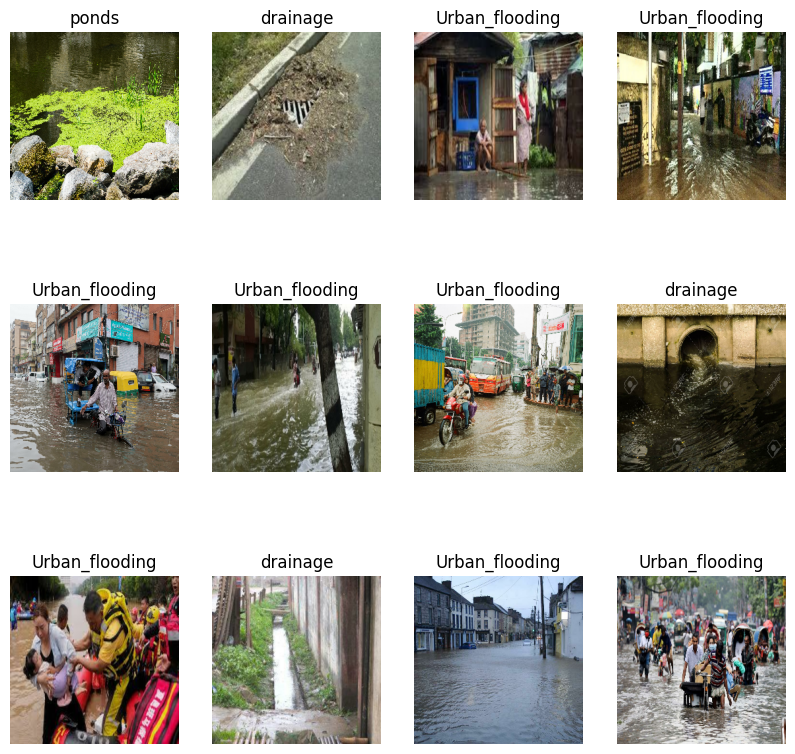

In [18]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [21]:
len(dataset)

81

In [22]:

# Define the path to the folder containing the PNG images
folder_path = data_dir # Change this to your folder path

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Filter the list to keep only PNG files
png_files = [file for file in files if file.endswith('.png')]

# Print the list of PNG files
for png_file in png_files:
    print(os.path.join(folder_path, png_file))


In [23]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
  ds_size=len(ds)

  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds

In [24]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)

64

In [26]:
len(val_ds)

8

In [27]:
len(test_ds)

9

In [28]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [30]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    ])

In [31]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
64/64 [==============================] - 98s 2s/step - loss: 1.0691 - accuracy: 0.4424 - val_loss: 1.0540 - val_accuracy: 0.4766
Epoch 2/100
64/64 [==============================] - 85s 1s/step - loss: 1.0573 - accuracy: 0.4419 - val_loss: 1.0350 - val_accuracy: 0.4766
Epoch 3/100
64/64 [==============================] - 83s 1s/step - loss: 1.0388 - accuracy: 0.4448 - val_loss: 0.9770 - val_accuracy: 0.5234
Epoch 4/100
64/64 [==============================] - 82s 1s/step - loss: 1.0132 - accuracy: 0.5254 - val_loss: 0.9418 - val_accuracy: 0.6172
Epoch 5/100
64/64 [==============================] - 81s 1s/step - loss: 0.9719 - accuracy: 0.5498 - val_loss: 0.8473 - val_accuracy: 0.6406
Epoch 6/100
64/64 [==============================] - 81s 1s/step - loss: 0.9371 - accuracy: 0.5654 - val_loss: 0.9856 - val_accuracy: 0.5430
Epoch 7/100
64/64 [==============================] - 81s 1s/step - loss: 0.9359 - accuracy: 0.5801 - val_loss: 0.9170 - val_accuracy: 0.5781
Epoch 8/100
6

In [37]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 10s 280ms/step - loss: 0.3630 - accuracy: 0.8299


In [38]:
scores

[0.36303478479385376, 0.8298611044883728]

In [39]:
history

In [40]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 64}

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
type(history.history['loss'])

list

In [43]:
len(history.history['loss'])

100

In [44]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0691039562225342,
 1.0573264360427856,
 1.0387717485427856,
 1.0131511688232422,
 0.9719354510307312]

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

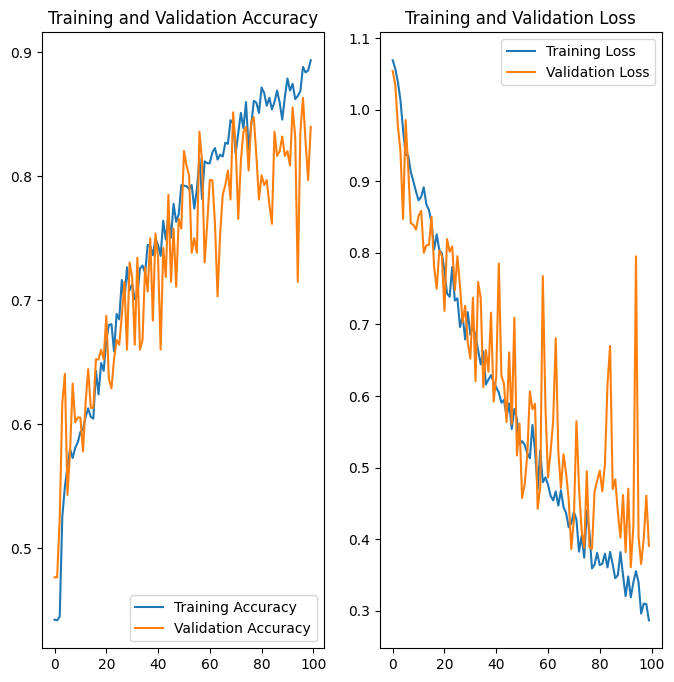

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: drainage
1/1 [==============================] - 1s 661ms/step
predicted label: drainage


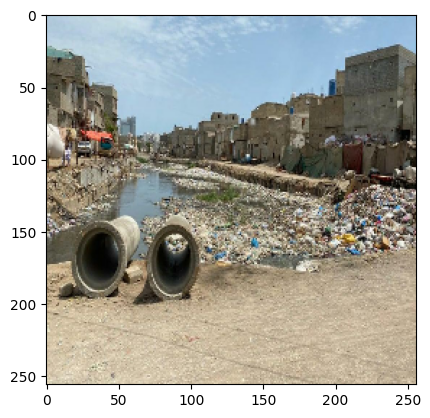

In [47]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


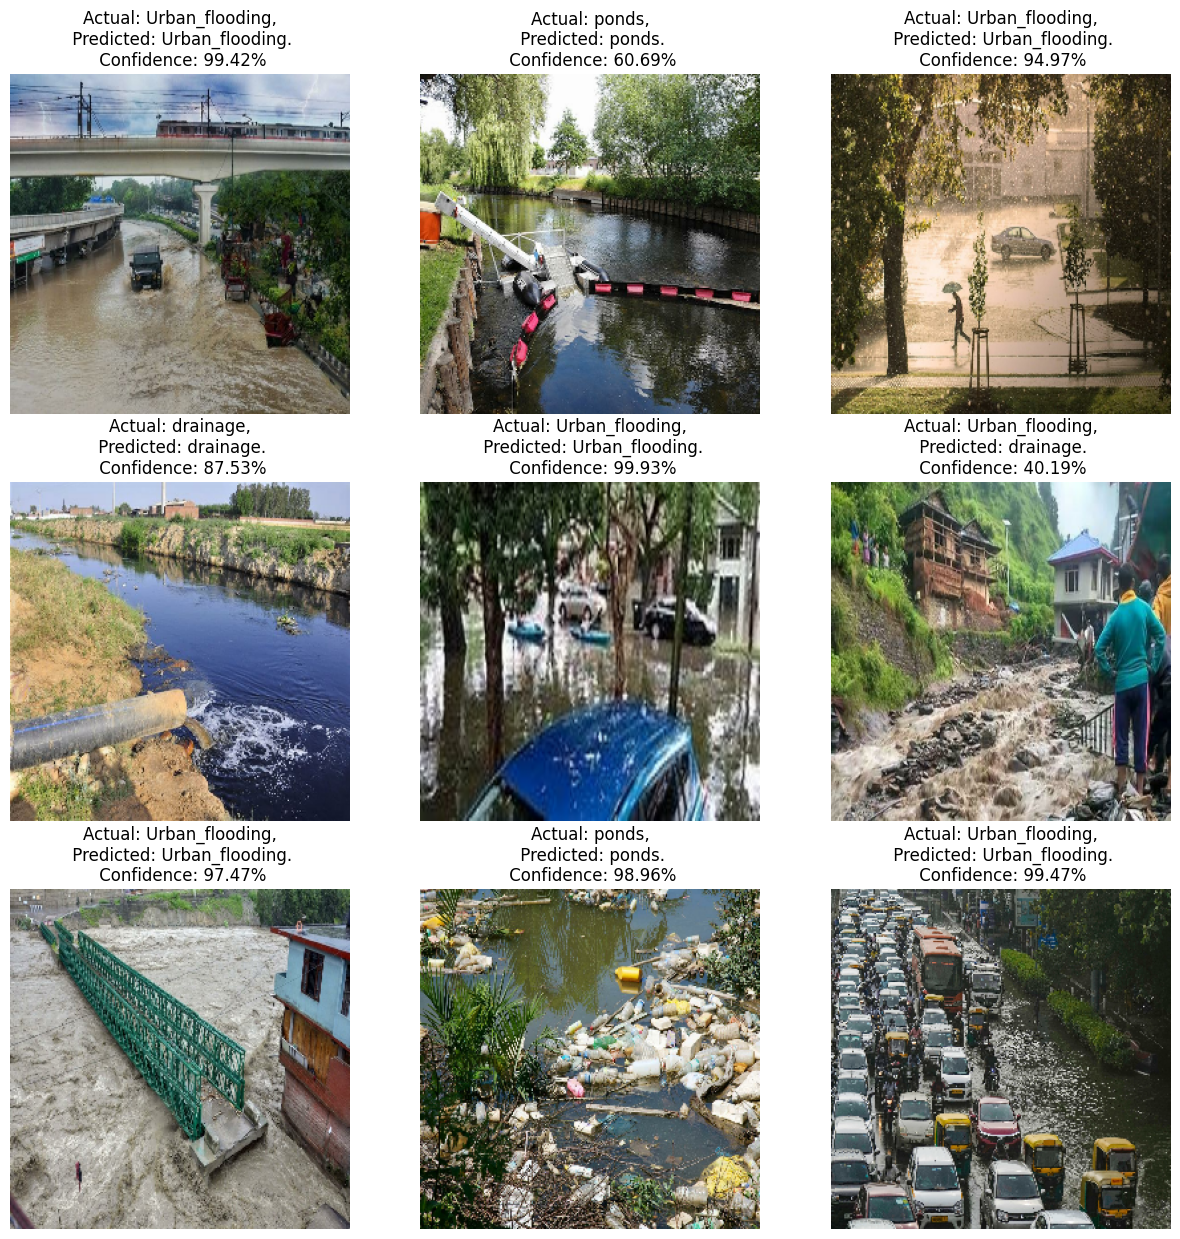

In [49]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [50]:
import os
model_version=max([int(i) for i in os.listdir("E:\Projects\Deep Learning Project SIH\Model\Model_3") + [0]])+1
model.save(f"E:\Projects\Deep Learning Project SIH\Model\Model_3\{model_version}")

INFO:tensorflow:Assets written to: E:\Projects\Deep Learning Project SIH\Model\Model_3\1\assets


INFO:tensorflow:Assets written to: E:\Projects\Deep Learning Project SIH\Model\Model_3\1\assets


In [51]:
model.save("E:\Projects\Deep Learning Project SIH\Model\Model_3\classifier_model2.h5")

C:\Users\dell\Anaconda\envs\Machinelearning\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
